In [1]:
import copy
import json
from calendar import monthrange
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
with open("history.json") as f:
    hist = json.load(f)

In [4]:
START = datetime(2021, 5, 12)
END = datetime.today()

## Organize history entry into hierarchal dictionary

In [5]:
metrics = {
    month: {
        day: {hour: [] for hour in range(24)}
        for day in range(1, monthrange(START.year, month)[1] + 1)
    }
    for month in range(START.month, END.month + 1)
}

for entry in hist:
    dt = datetime.fromtimestamp(entry["visitTime"] / 1000)
    if START <= dt and dt <= END:
        metrics[dt.month][dt.day][dt.hour].append(entry)

In [6]:
# Num of entries for 5/12 0:00 ~ 0:59
len(metrics[5][12][0])

108

## Calculate entry for each unit (hour)

In [7]:
metrics_len = []
extra_axes = START.weekday() + 1  # blank out some space to align plot in calendar style
curs = START - timedelta(days=extra_axes)
while curs <= END:
    # Add entry count for every hour of this day
    for hour in range(24):
        length = len(metrics[curs.month][curs.day][hour])
        # print(f"{curs.month}/{curs.day}:{hour} {length}")
        metrics_len.append(
            {
                "date": f"{curs.month}/{curs.day}",
                "hour": hour,
                "activity": length,
            }
        )
    curs += timedelta(days=1)  # Loop until end date is reached

## Plot in single chart

<AxesSubplot:>

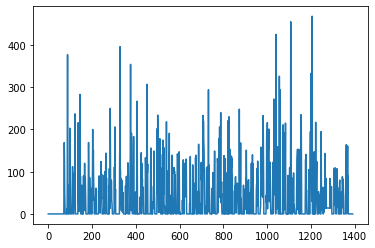

In [8]:
sns.lineplot(x=range(len(metrics_len)), y=[x["activity"] for x in metrics_len])

# Plot in calendar style

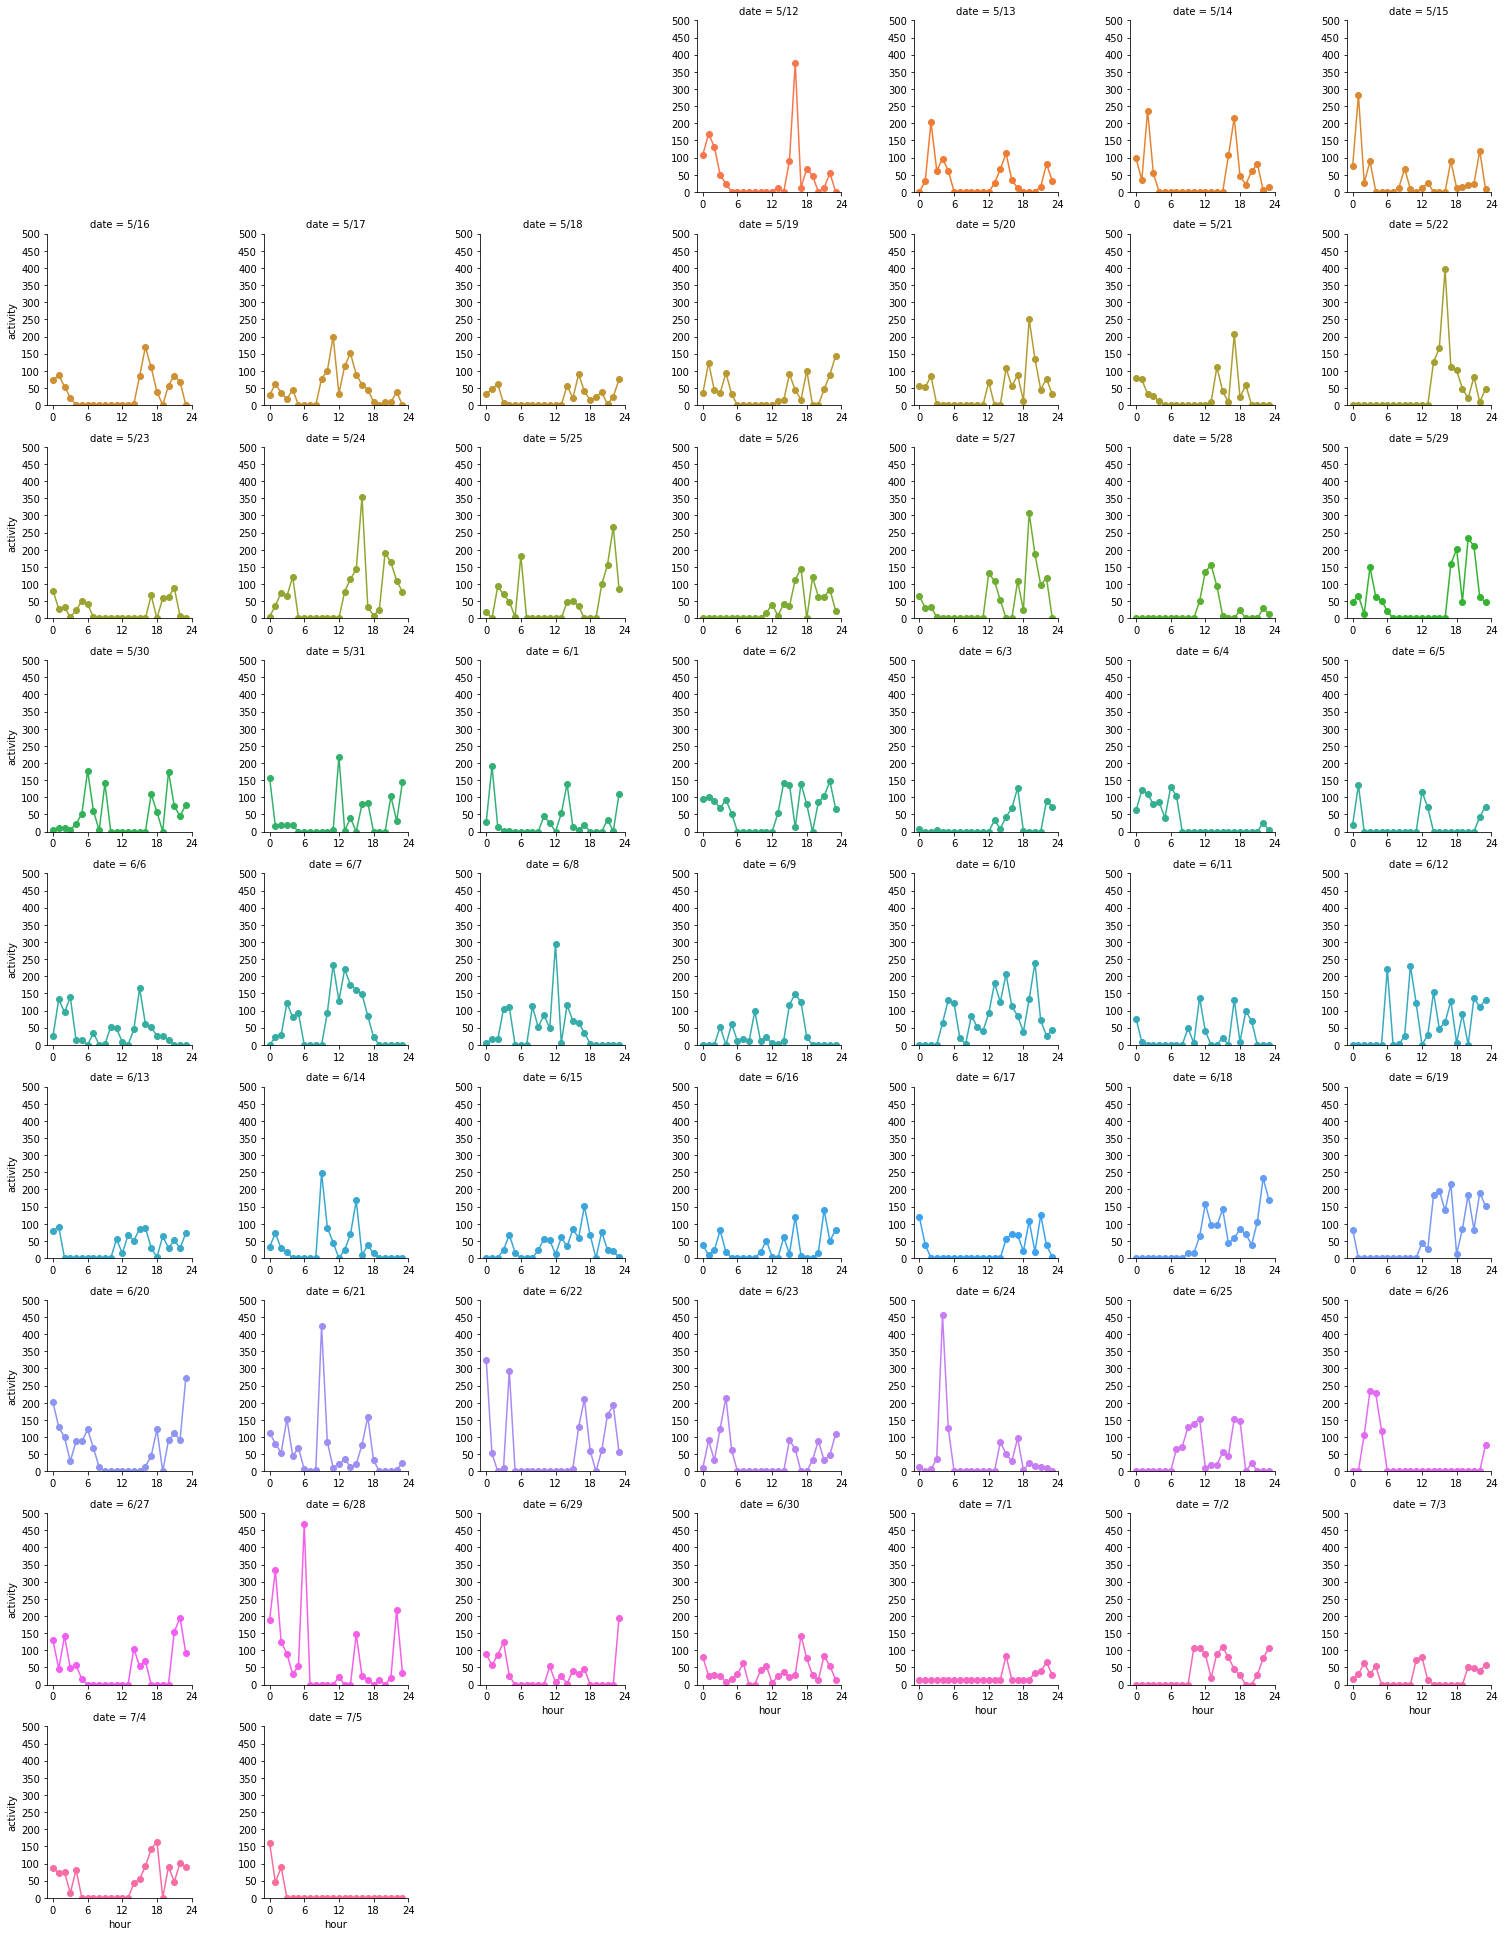

In [9]:
# Convert data to pandas DataFrame
df = pd.DataFrame.from_dict(metrics_len)
max_height = (max(df["activity"]) // 50 + 1) * 50

# Grid out plots with `date` as unit
grid = sns.FacetGrid(
    df, col="date", hue="date", col_wrap=7, sharex=False, sharey=False, legend_out=False
)

# Grid parameters
grid.set(
    xticks=[0, 6, 12, 18, 24],  # set ticks per 6 hours
    yticks=range(0, max_height + 1, 50),  # set ticks per 50 entry
    xlim=(-1, 24),  # width
    ylim=(0, max_height),  # height
)
grid.set_xlabels("")
grid.set_ylabels("")

# Plot value of `activity` with `hour` as unit
grid.map(plt.plot, "hour", "activity", marker="o")

# Set spacing between plots
# grid.tight_layout(w_pad=10)
grid.fig.subplots_adjust(wspace=0.5)

# Hide blank plots for space aligning
for axe in grid.fig.axes[:extra_axes]:
    axe.set_visible(False)

## Export Figure

In [10]:
grid.savefig("Full.png")

In [11]:
curs = START
for axe in grid.fig.axes[extra_axes:]:
    extent = axe.get_window_extent().transformed(grid.fig.dpi_scale_trans.inverted())
    grid.fig.savefig(
        f"{curs.strftime('%m%d')}.png", bbox_inches=extent.expanded(1.4, 1.2)
    )
    curs += timedelta(days=1)  # Loop until end date is reached